In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from WordTokenizer import WordPieceTokenizer
import random


In [32]:
class Word2VecDataset(Dataset):
    def __init__(self,text, WordPieceTokenizer:WordPieceTokenizer,context_size=2):
        self.tokenizer=WordPieceTokenizer
        self.vocabulary=self.tokenizer.get_vocabulary()
        self.token_word_to_dict={}
        self.context_size=context_size
        for i in range(len(self.vocabulary)):
            self.token_word_to_dict[self.vocabulary[i]]=i
        self.data=self.pre_process_data(text)
    def pre_process_data(self,text_file):
        with open(text_file,"r") as f:
            sentences=[line.strip() for line in f.readlines() if line.strip()]
        data=[]
        for sentence in sentences:
            list_of_tokens_for_sentence=self.tokenizer.tokenize_helper(sentence)
            
            for i in range(len(list_of_tokens_for_sentence)):
                list_of_context=[]
                
                for j in range(i-self.context_size,i+self.context_size+1):

                    if j<0 or j>=len(list_of_tokens_for_sentence):
                        list_of_context.append(1)
                        continue
                    if j==i:
                        continue
                    list_of_context.append(self.token_word_to_dict[list_of_tokens_for_sentence[j]])

                list_of_context_tensor=torch.tensor(list_of_context, dtype=torch.long)

                target_tensor=torch.tensor(self.token_word_to_dict[list_of_tokens_for_sentence[i]], dtype=torch.long)
                data.append((list_of_context_tensor,target_tensor))
        return data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_dimension):
        super(Word2VecModel, self).__init__()
        self.embedd = nn.Embedding(vocab_size, embedding_dimension)
        self.linear_layer = nn.Linear(embedding_dimension, vocab_size)
        self.trainlosshis = []
        self.vallosshis = []
        self.to(device)  # Move model to GPU

    def forward(self, context_):
        context_ = context_.to(device)  # Ensure input is on GPU
        embed_temp = self.embedd(context_).mean(dim=1)
        out_put_tex = self.linear_layer(embed_temp)
        return out_put_tex

    def train(self, train_loader, val_loader, epochs, learning_rate,optimizer="SGD"):
        lossfunction = nn.CrossEntropyLoss()
        self.opt=None
        if optimizer=="Adam":
            self.opt = optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer=="SGD":
            self.opt = optim.SGD(self.parameters(), lr=learning_rate)

        self.epochs=epochs
        for epoch in range(1,epochs+1):
            # Training phase
            trainlosstot = 0
            for context, target in train_loader:
                context = context.to(device)
                target=target.to(device)  # Move data to GPU

                self.zero_grad()
                outtemp = self(context)
                losstemp = lossfunction(outtemp, target)
                losstemp.backward()
                self.opt.step()
                trainlosstot += losstemp.item()
            
            avgtrain = trainlosstot / len(train_loader)
            self.trainlosshis.append(avgtrain)

            # Validation phase
            vallosstot = 0
            with torch.no_grad():  # No gradient calculation for validation
                for context, target in val_loader:
                    context = context.to(device)
                    target= target.to(device)
                    outtemp = self(context)
                    losstemp = lossfunction(outtemp, target)
                    vallosstot += losstemp.item()
            
            avgval = vallosstot / len(val_loader)
            self.vallosshis.append(avgval)
            print(f"For epoch --> {epoch}/{epochs}, training Loss is {avgtrain} and validation loss is {avgval}")

    def save_the_model(self,checkpoint_path):
        checkpoint_to_save = {
            "model_state_dict": self.state_dict(),
            "optimizer_state_dict": self.opt.state_dict(),
            "trainlosshistory": self.trainlosshis,
            "vallosshistory": self.vallosshis,
            "epochs": self.epochs + 1
        }

        torch.save(checkpoint_to_save, checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}")


    def plot_val_loss_vs_training_loss(self):
        plt.plot(range(1, self.epochs + 1), self.trainlosshis, label="Training Loss")
        plt.plot(range(1, self.epochs + 1), self.vallosshis, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.show()

    def compute_cosine_similarity(self):
        embedd_words=self.embedd.weight.data
        magnitude_of_vectors=torch.norm(embedd_words,p=2,dim=1,keepdim=True)
        norm_embed=embedd_words/magnitude_of_vectors
        sim_matrix=torch.mm(norm_embed,norm_embed.T)
        return sim_matrix

        
    def make_one_triplet(self,index,vocabulary,similairty_matrix):
        similarity_for_i_word=similairty_matrix[index]
        _,sim_indices=torch.topk(similarity_for_i_word,2)
        sim_indices_integer=sim_indices[1].item()
        dim_sim_ind=torch.argmin(similarity_for_i_word)
        dim_sim_index_int=dim_sim_ind.item()
        return (vocabulary[index],vocabulary[sim_indices_integer],vocabulary[dim_sim_index_int])

    def two_sim_one_disim_triplets(self,vocabulary):
        sim_matrix=self.compute_cosine_similarity()
        two_int=random.sample(range(len(vocabulary)),2)
        triplets_ret=[self.make_one_triplet(two_int[0],vocabulary,sim_matrix),self.make_one_triplet(two_int[1],vocabulary,sim_matrix)]
        return triplets_ret

Using device: cuda


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
x = torch.tensor([0.9998, 0.9997, 0.9991, 0.9998, 0.9996, 0.9996, 0.9997, 0.9995], dtype=torch.float64)
y,z=x.topk(2)
print(z[1].item())
print(x.argmin())

3
tensor(2)


In [20]:
print(random.sample(range(5),2))

[4, 1]


In [21]:
test_class=WordPieceTokenizer("corpus.txt","vocabulary_out.txt",100000,0)
test_class.construct_vocabulary()

{'i': ['i'], 'stand': ['s', '##t', '##a', '##n', '##d'], 'here': ['h', '##e', '##r', '##e'], 'feel': ['f', '##e', '##e', '##l'], 'empty': ['e', '##m', '##p', '##t', '##y'], 'a': ['a'], 'class': ['c', '##l', '##a', '##s', '##s'], 'post': ['p', '##o', '##s', '##t'], 'count': ['c', '##o', '##u', '##n', '##t'], 'link': ['l', '##i', '##n', '##k'], 'href': ['h', '##r', '##e', '##f'], 'http': ['h', '##t', '##t', '##p'], 'mooshilu': ['m', '##o', '##o', '##s', '##h', '##i', '##l', '##u'], 'literally': ['l', '##i', '##t', '##e', '##r', '##a', '##l', '##l', '##y'], 'just': ['j', '##u', '##s', '##t'], 'text': ['t', '##e', '##x', '##t'], 'tychelle': ['t', '##y', '##c', '##h', '##e', '##l', '##l', '##e'], 'to': ['t', '##o'], 'see': ['s', '##e', '##e'], 'if': ['i', '##f'], 'she': ['s', '##h', '##e'], 'wants': ['w', '##a', '##n', '##t', '##s'], 'hang': ['h', '##a', '##n', '##g'], 'out': ['o', '##u', '##t'], 'because': ['b', '##e', '##c', '##a', '##u', '##s', '##e'], 'reading': ['r', '##e', '##a', '##d

['[UNK]',
 '[PAD]',
 '##a',
 '##aachan',
 '##ab',
 '##abb',
 '##abbing',
 '##abl',
 '##ablish',
 '##ably',
 '##abour',
 '##abulous',
 '##aby',
 '##ac',
 '##acation',
 '##aceful',
 '##ach',
 '##achan',
 '##aching',
 '##achm',
 '##acious',
 '##ack',
 '##acking',
 '##aconic',
 '##acrific',
 '##act',
 '##actic',
 '##actica',
 '##actical',
 '##acting',
 '##action',
 '##actions',
 '##activ',
 '##actu',
 '##acul',
 '##ad',
 '##ada',
 '##adach',
 '##aday',
 '##aders',
 '##adership',
 '##adhan',
 '##adia',
 '##adiation',
 '##adiator',
 '##adical',
 '##ading',
 '##adings',
 '##adio',
 '##adition',
 '##adow',
 '##adphon',
 '##ads',
 '##adua',
 '##adually',
 '##aduation',
 '##ady',
 '##af',
 '##aff',
 '##affi',
 '##affic',
 '##affir',
 '##affirm',
 '##ag',
 '##agaz',
 '##agg',
 '##agging',
 '##agic',
 '##agious',
 '##agon',
 '##agu',
 '##agull',
 '##agulls',
 '##ah',
 '##aha',
 '##ahad',
 '##ahhh',
 '##ahoo',
 '##ai',
 '##aidhai',
 '##ail',
 '##ailabl',
 '##ailormoon',
 '##ailur',
 '##ain',
 '##ai

In [ ]:
dataset = Word2VecDataset("corpus.txt", test_class,2)

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 37225
Validation set size: 9307


In [34]:
print(dataset.token_word_to_dict)

{'[UNK]': 0, '[PAD]': 1, '##a': 2, '##aachan': 3, '##ab': 4, '##abb': 5, '##abbing': 6, '##abl': 7, '##ablish': 8, '##ably': 9, '##abour': 10, '##abulous': 11, '##aby': 12, '##ac': 13, '##acation': 14, '##aceful': 15, '##ach': 16, '##achan': 17, '##aching': 18, '##achm': 19, '##acious': 20, '##ack': 21, '##acking': 22, '##aconic': 23, '##acrific': 24, '##act': 25, '##actic': 26, '##actica': 27, '##actical': 28, '##acting': 29, '##action': 30, '##actions': 31, '##activ': 32, '##actu': 33, '##acul': 34, '##ad': 35, '##ada': 36, '##adach': 37, '##aday': 38, '##aders': 39, '##adership': 40, '##adhan': 41, '##adia': 42, '##adiation': 43, '##adiator': 44, '##adical': 45, '##ading': 46, '##adings': 47, '##adio': 48, '##adition': 49, '##adow': 50, '##adphon': 51, '##ads': 52, '##adua': 53, '##adually': 54, '##aduation': 55, '##ady': 56, '##af': 57, '##aff': 58, '##affi': 59, '##affic': 60, '##affir': 61, '##affirm': 62, '##ag': 63, '##agaz': 64, '##agg': 65, '##agging': 66, '##agic': 67, '##ag

14420
Word2VecModel(
  (embedd): Embedding(14420, 100)
  (linear_layer): Linear(in_features=100, out_features=14420, bias=True)
)
For epoch --> 1/100, training Loss is 9.194162087751828 and validation loss is 8.951700266284222
For epoch --> 2/100, training Loss is 8.795920978706727 and validation loss is 8.692180145237455
For epoch --> 3/100, training Loss is 8.56272470172738 and validation loss is 8.494803579402543
For epoch --> 4/100, training Loss is 8.368074175418448 and validation loss is 8.31686725813089
For epoch --> 5/100, training Loss is 8.183677623362065 and validation loss is 8.149206887405763
For epoch --> 6/100, training Loss is 8.014509416937418 and validation loss is 7.999061676235134
For epoch --> 7/100, training Loss is 7.864704970641644 and validation loss is 7.869767618343183
For epoch --> 8/100, training Loss is 7.736463881849833 and validation loss is 7.760314712000057
For epoch --> 9/100, training Loss is 7.625126784200111 and validation loss is 7.66569371567559


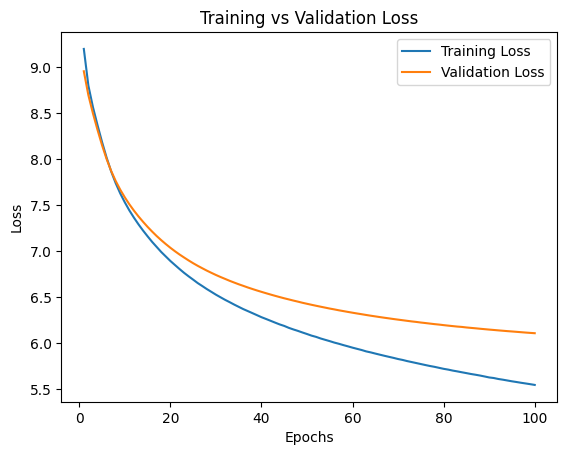

In [70]:
vocab_size = len(test_class.get_vocabulary()) # Replace with actual vocabulary size
print(vocab_size)
embedding_dim = 100
model=Word2VecModel(vocab_size,embedding_dim)
print(model)
model.train(train_loader,val_loader,100,0.01)
model.save_the_model("Word2VecCheckpoint.pth")
model.plot_val_loss_vs_training_loss()

14420
Word2VecModel(
  (embedd): Embedding(14420, 100)
  (linear_layer): Linear(in_features=100, out_features=14420, bias=True)
)
For epoch --> 1/100, training Loss is 6.393974537497124 and validation loss is 6.0516673625539665
For epoch --> 2/100, training Loss is 4.338985832696109 and validation loss is 6.380277663162074
For epoch --> 3/100, training Loss is 3.0710222420004225 and validation loss is 7.045336751184103
For epoch --> 4/100, training Loss is 2.2989525137488376 and validation loss is 7.679915624795501
For epoch --> 5/100, training Loss is 1.8725258782249956 and validation loss is 8.260866001299567
For epoch --> 6/100, training Loss is 1.6472548406148695 and validation loss is 8.848991280978488
For epoch --> 7/100, training Loss is 1.4932301537841046 and validation loss is 9.394517685539533
For epoch --> 8/100, training Loss is 1.4025815092411238 and validation loss is 9.84934345225698
For epoch --> 9/100, training Loss is 1.332120503039704 and validation loss is 10.307341

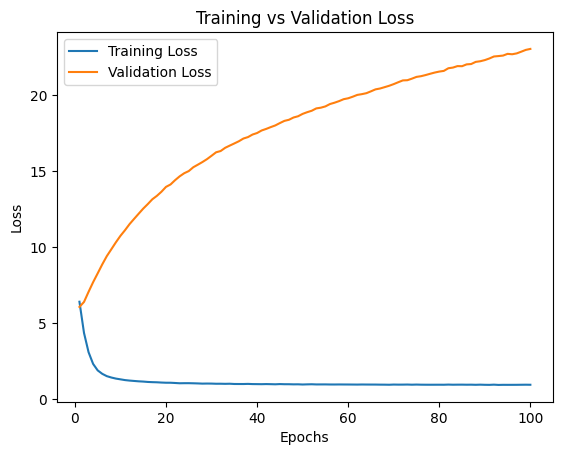

In [76]:
vocab_size = len(test_class.get_vocabulary()) # Replace with actual vocabulary size
print(vocab_size)
embedding_dim = 100
model1=Word2VecModel(vocab_size,embedding_dim)
print(model)
model1.train(train_loader,val_loader,100,0.01,"Adam")
model1.save_the_model("Word2VecCheckpoint.pth")
model1.plot_val_loss_vs_training_loss()

In [ ]:
vocab_size = len(test_class.get_vocabulary()) # Replace with actual vocabulary size
print(vocab_size)
embedding_dim = 100
model1=Word2VecModel(vocab_size,embedding_dim)
print(model1)

In [ ]:
model1.train(train_loader,val_loader,100,0.01,"Adam")


In [39]:
# def compute_cosine_similarity(test):
#     embedd_words=test.embedd.weight.data
#     magnitude_of_vectors=torch.norm(embedd_words,p=2,dim=1,keepdim=True)
#     norm_embed=embedd_words/magnitude_of_vectors
#     sim_matrix=torch.mm(norm_embed,norm_embed.T)
#     return sim_matrix
    
# def make_one_triplet(test,index,vocabulary,similairty_matrix):
#     similarity_for_i_word=similairty_matrix[index]
#     _,sim_indices=torch.topk(similarity_for_i_word,2)
#     sim_indices_integer=sim_indices[1].item()
#     dim_sim_ind=torch.argmin(similarity_for_i_word)
#     dim_sim_index_int=dim_sim_ind.item()
#     return (vocabulary[index],vocabulary[sim_indices_integer],vocabulary[dim_sim_index_int])

# def two_sim_one_disim_triplets(test,vocabulary):
#     sim_matrix=compute_cosine_similarity(test)
#     two_int=random.sample(range(len(vocabulary)),2)
#     triplets_ret=[make_one_triplet(test,two_int[0],vocabulary,sim_matrix),make_one_triplet(test,two_int[1],vocabulary,sim_matrix)]
#     return triplets_ret

In [43]:
# two_sim_one_disim_triplets(model,dataset.vocabulary)

[('delive', 'emptied', '##gic'), ('##gac', '##refor', 'describe')]